In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [40]:
# from fastai.imports import *
# from fastai.structured import *
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from utils import *

In [28]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [29]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [30]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

In [31]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(
            self.x.iloc[rnd_idxs], 
            self.y[rnd_idxs], 
            idxs=np.array(range(self.sample_sz)),
            min_leaf=self.min_leaf
        )
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [32]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        # store all values in the root of the tree
        if idxs is None: 
            idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n = len(idxs)
        self.c = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    # assumes that max_features is set to all
    def find_varsplit(self):
        for i in range(self.c): 
            self.find_better_split(i)
        if self.is_leaf:
            return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])
            
    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

        sort_idx = np.argsort(x)
        sort_x = x[sort_idx]
        sort_y = y[sort_idx]
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi**2 
            rhs_sum2 -= yi**2
            if i < self.min_leaf - 1 or xi == sort_x[i+1]:
                continue

            lhs_std = self.std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = self.std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = xi
                
    def std_agg(self, cnt, s1, s2): 
        return math.sqrt((s2/cnt) - (s1/cnt)**2)
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    
    def predict_row(self, xi):
        if self.is_leaf:
            return self.val
        if xi[self.var_idx] <= self.split:
            t = self.lhs
        else:
            t = self.rhs
        return t.predict_row(xi)
    
    @property
    def split_name(self): 
        return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): 
        return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self): 
        return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

In [33]:
m = TreeEnsemble(x_sub, y_train, n_trees=10, sample_sz=1000, min_leaf=3)
m.trees[0]

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [34]:
m.trees[0].idxs[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
x_sample, y_sample = m.trees[0].x, m.trees[0].y
x_sample.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [36]:
m.trees[0]

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [37]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']
tree = TreeEnsemble(X_train[cols], y_train, 1, 1000)

In [38]:
%time preds = tree.predict(X_valid[cols].values)

Wall time: 75 ms


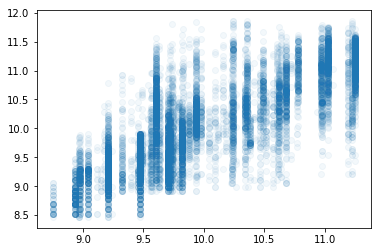

In [41]:
plt.scatter(preds, y_valid, alpha = 0.05)

In [42]:
metrics.r2_score(preds, y_valid)

0.4840854669925271

In [43]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)

In [44]:
preds = ens.predict(X_valid[cols].values)

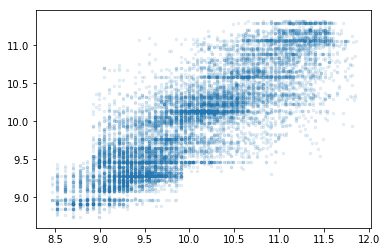

In [45]:
plt.scatter(y_valid, preds, alpha=0.1, s=6)

In [51]:
metrics.r2_score(y_valid, preds)

0.7025757322910476